Data storytelling
=====

##### Important concepts
* ENG - Electrical Number Group - a grouping used to divide product into rough categories.
* ETIM class - a grouping used to divide products into detailed categories.
* Technical description - a text field describing each product.

In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

# Change working directory to get the file
os.chdir('/Users/pkg/Springboard')

# Open pickled file from the data wrangling section and set working directory
with open('data_wrangling.pickle', 'rb') as handle:
    df = pickle.load(handle)
    
os.chdir('/Users/pkg/Springboard/Intermediate Data Science with Python/Python_Capstone')


Let's start off with some basic descriptive statistics.

In [2]:
# Some basic statistics
df.describe()

,EN_group,ETIM_class,Technical_description
count,202216,202216,202216
unique,41,1814,109429
top,43,EC000042,"Spasial serien består av stål Bokser typeS44,S..."
freq,20761,5630,1772


Some notes of interest:
* There are 41 unique ENGs, and 1814 unique ETIM classes that have been used in the current selection of the product database. It will be interesting to see how the different ETIM classes are distributed within each ENG.
* The most popular ENG is used for more than 10% of the products. How is the distribution of products within each ENG?
* Although there are no missing technical descriptions, there are only about half as many as there are products. This must mean that there are some technical descritions that are used for different products. This most popular descrition is used 1772 times. How is this distributed? And what kind of product can have the same description so many times - does this make sense?
* One would expect near-identical products to share a similar technical description. If the products are dissimilar, and yet have the same techincal description, one would expect this to be problem that needs to be investiagted further. Are there identical technical descriptions that are used for products in different ENGs or ETIM classes? If so, how prevalent is this?

Let's first look at how the ETIM classes are distributed within each ENG.

### ETIM classes within the ENGs

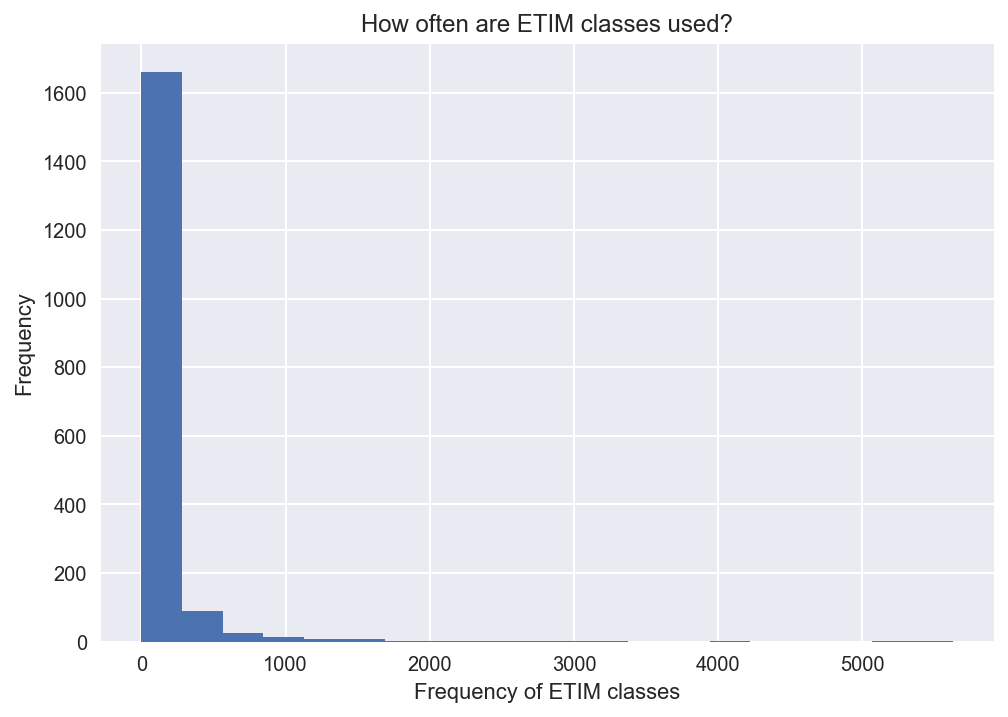

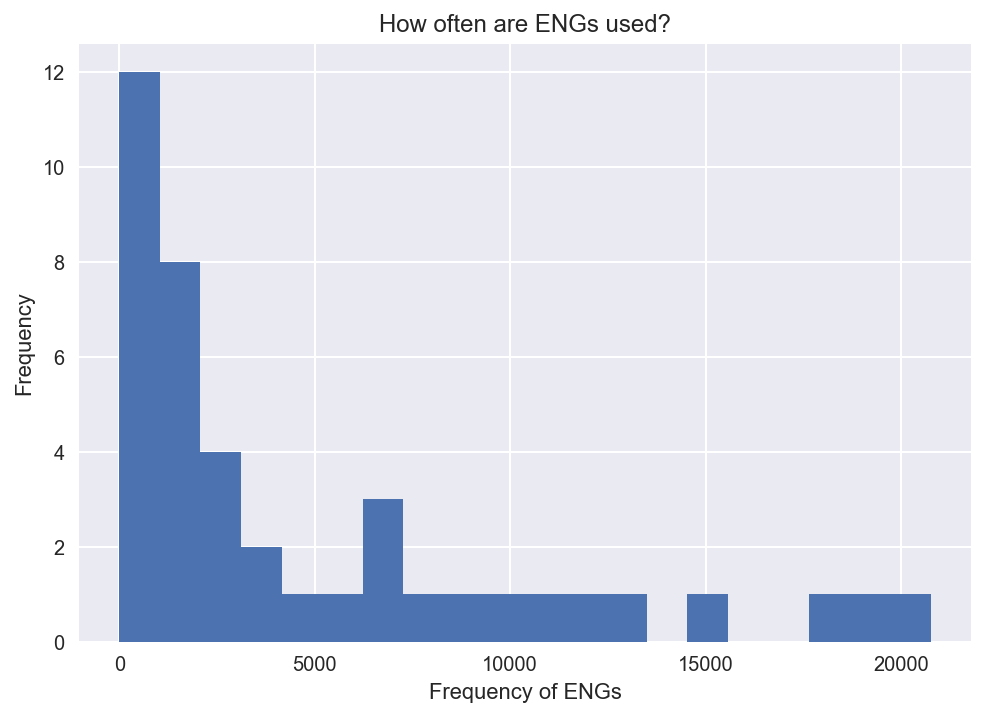

In [3]:
# How are the frequencies distributed within each ETIM-class and ENG?
ETIM_counts = df['ETIM_class'].value_counts()
ENG_counts = df['EN_group'].value_counts()

# Plot the ETIM counts
plt.hist(ETIM_counts, bins=20)
plt.xlabel('Frequency of ETIM classes')
plt.ylabel('Frequency')
plt.title('How often are ETIM classes used?')
plt.show()

# Plot the ENG counts
plt.hist(ENG_counts, bins=20)
plt.xlabel('Frequency of ENGs')
plt.ylabel('Frequency')
plt.title('How often are ENGs used?')
plt.show()

There's clear skewing in both the ETIM classes and the ENGs. But instead of looking at them individually, let's look at the patterns for both variables.

In [4]:
# How many of each ETIM-class are there within each elnr group?
grouped = pd.DataFrame(df.groupby(['EN_group', 'ETIM_class']).size())
grouped.columns = ['freq']
grouped = grouped.sort_values(['freq'],ascending=False).sort_index(axis=0,
                             level='EN_group', ascending=True,
                             sort_remaining=False)

print(grouped.shape)
grouped.head(20)

(3815, 1)


freq
EN_group ETIM_class      
10       EC003250    5146
         EC003248    4819
         EC003251    2845
         EC003249    1779
         EC000034    1195
         EC000339    1144
         EC000405     639
         EC000839     288
         EC000019     261
         EC001476     207
         EC002063     136
         EC002065      91
         EC000247      67
         EC001139      66
         EC000838      65
         EC000065      62
         EC000340      58
         EC002904      31
         EC001474      18
         EC000441      11

The ENG and ETIM class is put into a multilevel index, with the frequency as the only variable. It's clear from looking at the top 20 in ENG 10 that the data is skewed, there are a few ETIM classes that are used frequently, and then it's reduced quickly. The transformed dataset is still 3815 rows long, with just 41 ENGs, which indicates lengthy tails within each ENG. How does this look?

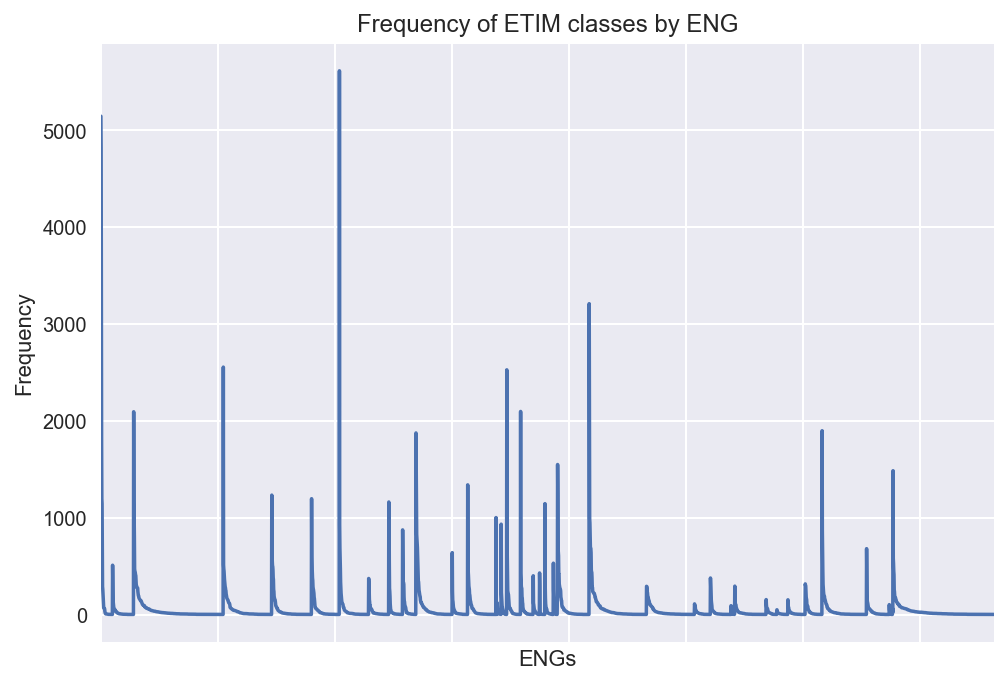

In [5]:
# Display the grouped dataset
grouped['freq'].plot()
plt.xlabel('ENGs')
plt.ylabel('Frequency')
plt.title('Frequency of ETIM classes by ENG')
plt.tick_params(labelbottom=False)
#plt.rcParams['figure.figsize'] = [6, 3]
#plt.figure(figsize=(6,3))
plt.show()

As suspected, the ENGs usually have a peak of a few ETIM class that dwarfs all other ETIM classes within that ENG. The fall-off is very steep, and most ENGs have a high numbers of ETIM classes that are used rarely.

### Is there a clear cut-off point for rare ETIM classes?

For prediction purposes, seldom used ETIM classes within an ENG won't be useful. At some point, there just isn't enough data to be used for prediction. If the data is trimmed according to frequency, how much is lost?

In [6]:
# How much of the data is lost if data with lower frequencies are trimmed?
for i in [1, 10, 50, 100, 200, 500]:
    numerator = grouped[grouped['freq'] > i].sum()
    fraction = numerator / grouped.sum()
    print("% of data left if i is " + str(i) + " is: " + str(fraction)[8:13])

% of data left if i is 1 is: 0.996
% of data left if i is 10 is: 0.963
% of data left if i is 50 is: 0.859
% of data left if i is 100 is: 0.761
% of data left if i is 200 is: 0.637
% of data left if i is 500 is: 0.424


If the cut-off point is 50, about 1 in 6 products are discarded for prediction purposes. The points above give a decent overview, but for completeness, let's also plot the whole curve.

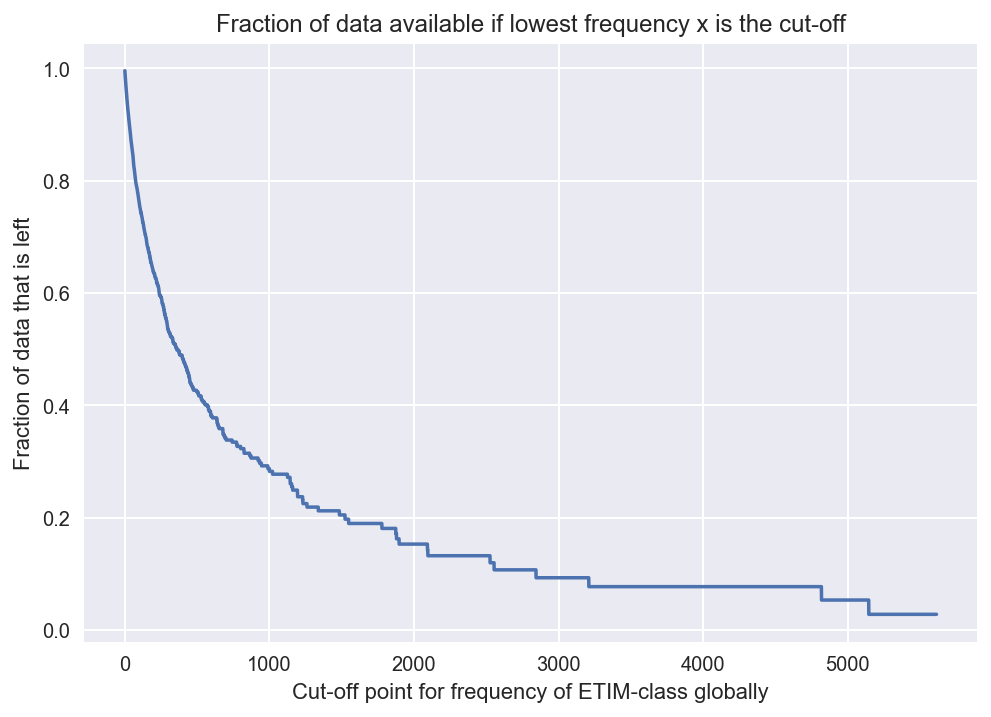

In [7]:
# How much of the data is left if data with lower frequencies are trimmed?
x = []
y = []
for i in range(1, max(grouped['freq'])):
    numerator = grouped[grouped['freq'] > i].sum()
    fraction = numerator / grouped.sum()
    x.append(i)
    y.append(fraction.iloc[0])

plt.plot(x, y)
plt.xlabel('Cut-off point for frequency of ETIM-class globally')
plt.ylabel('Fraction of data that is left')
plt.title('Fraction of data available if lowest frequency x is the cut-off')
plt.show()

The sheer size of the graph makes it difficult to discern minor changes at the higher bound of the graph. Let's zoom in on that area to see if there is an interesting pattern there.

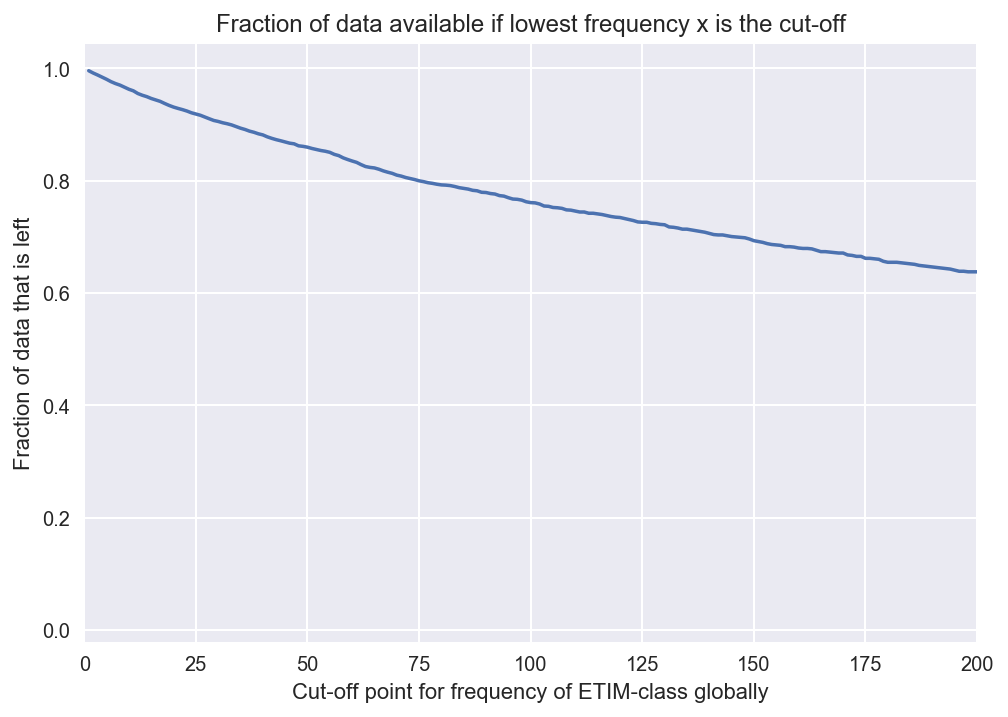

In [8]:
# How much of the data is left if data with lower frequencies are trimmed?
# Zoomed in on the first 200
plt.plot(x, y)
plt.xlabel('Cut-off point for frequency of ETIM-class globally')
plt.ylabel('Fraction of data that is left')
plt.title('Fraction of data available if lowest frequency x is the cut-off')
plt.xlim(0, 200)
plt.show()

There doesn't seem to be any patterns visible on this metric. How the cut-off point is chosen must be decided later, when the model can be tuned with this hyperparameter in mind.

### Technical descriptions

How is the frequency distribution of the technical descriptions?

In [9]:
# Create counts for the Technical description
TD_counts = df['Technical_description'].value_counts()

# View some random Technical descriptions
TD_counts.sample(5, random_state=8)

OSRAM PARATHOM® HQL LED. Robust , høy flux LED-lampe for krevende applikasjoner. IP65 beskyttelse og energibesparelse på opp til 78% når du bytter ut med tilsvarende kvikksølvlamper (HQL). Effektiv varmestyring for et bredt temperaturområde på -20 og opp til +60° C. Ekstremt lang levetid på opp til 50000 timer, høyt overspenningsvern på opp til 4 kV (L-N), ingen oppvarmingstid, gir 100% lys øyeblikkelig. Anbefalte bruksområder er gatebelysning, parkeringsplasser, gangveier, parker og industri installasjoner. Må kun bukes i egnede armaturer. Må kobles utenom forkobling og rett på nettspenning. Spesifikasjoner for Elnr 3720131: Lumen 13000lm , 4000 Kelvin, 220-240 V, 95W tilsvarer 250W tradisjonell, 840 farge, Ra>80, utstrålingsvinkel 280°, 50 000 timer, IP65, no dim, E40 sokkel. A+ Etim: EC001959 LED-lamp/Multi-L    1
·Gullfarget metalldeksel  ·LED dimbar mignon Incanda pære - LC0803,5dCT ·E14 sokkel                                                                                        

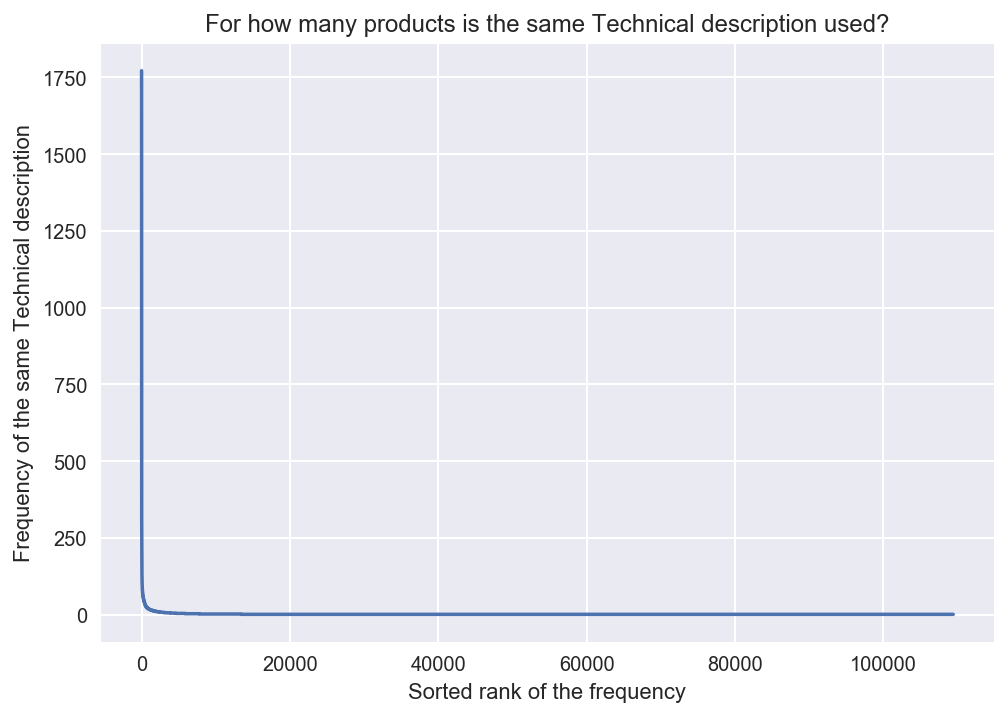

In [10]:
# Distribution of the frequency of the Technical description
z = []
for index, val in TD_counts.iteritems():
    z.append(val)

plt.plot(z)
plt.xlabel('Sorted rank of the frequency')
plt.ylabel('Frequency of the same Technical description')
plt.title('For how many products is the same Technical description used?')
plt.show()

This shows that a miniscule portion of the technical descriptions are re-used heavily. Let's take a closer look.

The 99.9th percentile of z is: 82.0
The 99th percentile of z is: 17.0
The 95th percentile of z is: 4.0
The 90th percentile of z is: 2.0
The 75th percentile of z is: 1.0
The 50th percentile of z is: 1.0
The 25th percentile of z is: 1.0


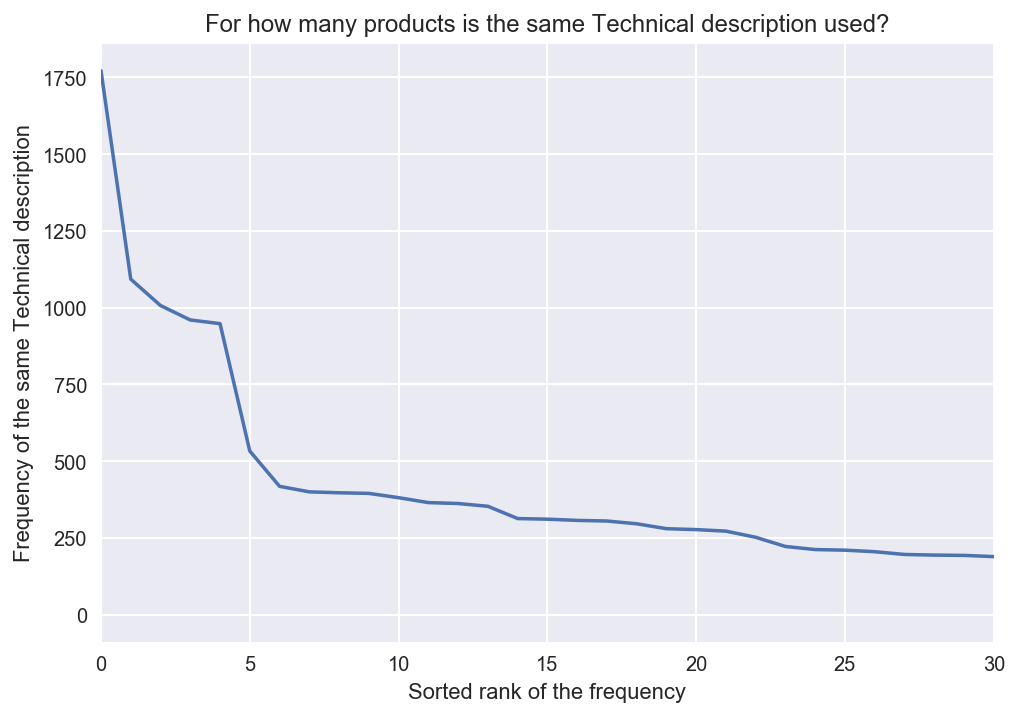

In [11]:
# Distribution of the frequency of the Technical description, a closer look
for i in [99.9, 99, 95, 90, 75, 50, 25]:
    perc = np.percentile(z, i)
    print("The " + str(i) + "th percentile of z is: " + str(perc))

# Plotting the graph for the 30 most used technical descriptions
plt.plot(z)
plt.xlabel('Sorted rank of the frequency')
plt.ylabel('Frequency of the same Technical description')
plt.title('For how many products is the same Technical description used?')
plt.xlim(0,30)
plt.show()

Of the 109 429 unique technical descriptions, the most common frequency is one. The 95th percentile is four, and products in the 99.9th percentile are used 82 times or more. At the very top the five most used are used more than 500 times. From there, it seems to slowly taper off.

This peculiar pattern poses a challenge for the predictions, as there are so many technical descriptions that are identical at the extreme end of the ranked frequency. In order to investigate a little bit further, let's look at how the ETIM-classes are distributed within the top five used technical descriptions.

In [12]:
# Show rank, the number of products that share the same technical description, ENGs and ETIM classes
# for the ten most used technical descriptions
for i in range(0,10):
    by_TD = df[TD_counts.index[i] == df['Technical_description']][['EN_group', 'ETIM_class']]
    print("Rank " + str(i+1), '\n'
    "Products with the same technical description: " + str(TD_counts[i]), '\n''\n'
    "First part of text: " + str(TD_counts.index[i][:200]), '\n''\n'
    "ENG(s): " + str(by_TD['EN_group'].unique()), '\n''\n'
    "ETIM class(es): " + str(np.sort(by_TD['ETIM_class'].unique())), '\n''\n''\n''\n')

Rank 1 
Products with the same technical description: 1772 

First part of text: Spasial serien består av stål Bokser typeS44,S57,S24 og SDB , Veggmonterte skap type S3D Veggmonterte S3X og S3Dxex skap, Gulvmonterte skap type SF,SM,SMX og SFX Kontrollpulter type SD, SDFog SDX , X  

ENG(s): ['24' '25'] 

ETIM class(es): ['EC000022' 'EC000096' 'EC000211' 'EC000213' 'EC000240' 'EC000261'
 'EC000317' 'EC000322' 'EC000327' 'EC000329' 'EC000456' 'EC000482'
 'EC000721' 'EC000743' 'EC000744' 'EC000747' 'EC000771' 'EC000775'
 'EC000784' 'EC000887' 'EC000889' 'EC001154' 'EC001166' 'EC001167'
 'EC001174' 'EC001285' 'EC002358' 'EC002502' 'EC002504' 'EC002518'
 'EC002524' 'EC002525' 'EC002530' 'EC002617' 'EC002620' 'EC002621'
 'EC002622' 'EC002623' 'EC002624' 'EC002625' 'EC002626' 'EC002627'] 




Rank 2 
Products with the same technical description: 1093 

First part of text: Techno Module  Techno Module er et moderne, patentert modulært konstruksjonssystem for bygging av lavsspennings brytertavl

Here something quite interesting is visible. Up until now, the assumption was that all technical descriptions were in fact technical descriptions. But the 6th and 9th ranked technical descriptions are actually filler text; "Description not available" and "See goods description field". This is important, and to see why, look at the 6th ranked product. It has 14 different ENGs! This is extremely unlikely to be true, even if there are 533 products in this rank. This could never be used to predict anything.

For all ranks other than the 6th and 9th, only one or two ENGs have been used, and if there are two, they are similar. For instance, ENG 24 and 25 are different types of cabinets. One would assume that different cabinets might use the same technical description.

While theoretically feasable, it would be a lot of manual labor to look through all technical descriptions where there were more than one ENG. Instead, the intuition that there should be few and similar ENGs can be used to pick out supsicious technical descriptions. This is useful for two reasons: It helps with the model in this project and it should be fixed in the database.

Let's do this now. From experimentation, it's time-consuming to test all technical descriptions that are used for more than one product. Here, both the code for all of these products, and for the top 2000 are available. The top 2000 are used, as there are no additional value from the descriptions above this rank.

In [13]:
# Find the last rank where a technical description is used more than once

# i = 0
# while (TD_counts[i] > 1):
#     i = i+1
# last = int(i)
# print(i)

limit = 2000

In [14]:
# List all technical descriptions that are used in more than two ENGs
for i in range(0,limit):
    by_TD = df[TD_counts.index[i] == df['Technical_description']][['EN_group', 'ETIM_class']]
    if len(by_TD['EN_group'].unique()) > 2:
        print("Rank " + str(i+1), '\n'
        "Products with the same technical description: " + str(TD_counts[i]), '\n''\n'
        "First part of text: " + str(TD_counts.index[i][:200]), '\n''\n'
        "ENG(s): " + str(by_TD['EN_group'].unique()), '\n''\n'
        "ETIM class(es): " + str(np.sort(by_TD['ETIM_class'].unique())), '\n''\n''\n''\n')

Rank 6 
Products with the same technical description: 533 

First part of text: Beskrivelse ikke tilgjengelig 

ENG(s): ['12' '13' '15' '16' '18' '43' '45' '49' '54' '62' '64' '66' '80' '88'] 

ETIM class(es): ['EC000320' 'EC000381' 'EC000437' 'EC000441' 'EC000472' 'EC000489'
 'EC000491' 'EC000494' 'EC000524' 'EC000536' 'EC000608' 'EC000610'
 'EC000737' 'EC000761' 'EC000886' 'EC000897' 'EC000899' 'EC000900'
 'EC000901' 'EC000902' 'EC000903' 'EC000940' 'EC001041' 'EC001134'
 'EC001257' 'EC001262' 'EC001283' 'EC001284' 'EC001288' 'EC001419'
 'EC001437' 'EC001440' 'EC001504' 'EC001530' 'EC001599' 'EC001666'
 'EC001855' 'EC002255' 'EC002541' 'EC002555' 'EC002557' 'EC002636'
 'EC002653'] 




Rank 143 
Products with the same technical description: 71 

First part of text: Diverse skinne- og montasjemateriell for industritavlebygging. 

ENG(s): ['12' '24' '41'] 

ETIM class(es): ['EC000012' 'EC000213' 'EC000386' 'EC000727' 'EC000887' 'EC001285'
 'EC001522' 'EC001531' 'EC002270' 'EC002358' 'E

In addition to rank 6 "Description not available", there is one description where the text is simply "0", which is also bad data. Here the text is suspiciously short. Let's look for more bad data by only checking technical descriptions with five or fewer characters.

In [15]:
# List all technical descriptions shorter then five characters
for i in range(0,limit):
    by_TD = df[TD_counts.index[i] == df['Technical_description']][['EN_group', 'ETIM_class']]
    if len(TD_counts.index[i]) < 5:
        print("Rank " + str(i+1), '\n'
        "Products with the same technical description: " + str(TD_counts[i]), '\n''\n'
        "First part of text: " + str(TD_counts.index[i][:5]), '\n''\n'
        "ENG(s): " + str(by_TD['EN_group'].unique()), '\n''\n'
        "ETIM class(es): " + str(np.sort(by_TD['ETIM_class'].unique())), '\n''\n''\n''\n')

Rank 1727 
Products with the same technical description: 12 

First part of text: 0 

ENG(s): ['14' '41' '88'] 

ETIM class(es): ['EC000216' 'EC002239' 'EC002498'] 






There doesn't seem to be any other unlikely short technical descriptions that should be cleaned.

The products with the following technical descriptions are now removed:
* "Description not available"
* "See goods description field"
* "0"

In [16]:
# Create the boolean series to remove unwanted technical descriptions
removals = (df['Technical_description'] == '0') | (df['Technical_description'] == 'Beskrivelse ikke tilgjengelig') | (df['Technical_description'] == 'Se varebetegnelse')

# Count the sum of the removals
nr_removals = sum(removals)
print(nr_removals)

# Drop the unwanted products based on their technical descriptions
before = df.shape[0]
df = df.drop(df[removals].index)
print(df.shape[0] + nr_removals == before)

942
True


The technical descriptions that have obvious bad data is now discovered and removed. It's time to move on to the next part of the project. But first, the remaining dataset is pickled.

In [17]:
# Set working directory and save the data set as a pickled object.
os.chdir('/Users/pkg/Springboard')
with open('data_storytelling.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)